In [2]:
import sys
import time
import pandas as pd
from sklearn import model_selection
from sklearn import ensemble, linear_model, svm, metrics, cluster, tree
from xgboost import XGBRegressor
from matplotlib import pyplot as plt
import scipy
import os
import numpy as np
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import preprocessing
from sklearn.feature_selection import *
from sklearn.model_selection import GridSearchCV, KFold

start_time = time.time()

n_cv = 5
n_jobs = 4
random_state = 3111696
d_set = "Galaxy215-[rTRAIL.csv].tabular"

print("Loading dataset: %s" % d_set)
df = pd.read_csv("depmap/" + d_set, sep="\t")
columns = list(df.columns.values)
label = df[columns[-1]].copy()
data = df.drop(columns[-1], axis=1)
print(data.shape)
print(label.shape)
print("Dataset loaded")

Loading dataset: Galaxy215-[rTRAIL.csv].tabular
(604, 48117)
(604,)
Dataset loaded


In [3]:
print('Feature extraction started...')

clf = XGBRegressor(n_estimators=100, random_state=random_state)
clf = clf.fit(data, label)
model = SelectFromModel(clf, prefit=True)
extracted_features_data = model.transform(data)

print("Size low dimensional data: ", extracted_features_data.shape)
print('Feature extraction finished')

Feature extraction started...
Size low dimensional data:  (604, 454)
Feature extraction finished


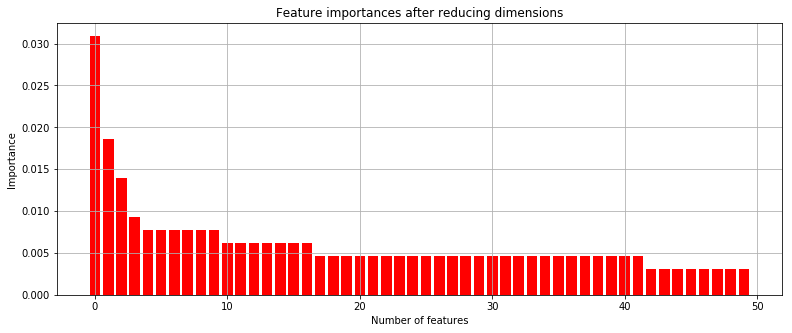

Size low dimensional data:  (604, 50)
Fitting 5 folds for each of 2 candidates, totalling 10 fits
{'regression_ld__fit_intercept': True}
0.15
Total time taken: 530 seconds


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished
/home/anupkumar/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [13]:
f_importances = clf.feature_importances_
indices_ld = np.argsort(f_importances)[::-1]
topk = 50

indices_ld = indices_ld[:topk]

plt.figure(figsize=(13, 5))
plt.title("Feature importances after reducing dimensions")
plt.bar(range(topk), f_importances[indices_ld], color="r")
plt.xlabel("Number of features")
plt.ylabel("Importance")
plt.grid(True)
plt.show()

new_data = np.zeros([data.shape[0], topk])
for idx in range(topk):
    new_data[:, idx] = data.iloc[:, indices_ld[idx]].values
print("Size low dimensional data: ", new_data.shape)

pipe_regressor_ld = Pipeline([
    ('regression_ld', linear_model.LinearRegression())
])

parameters_ld = [
    {   
        'regression_ld__fit_intercept': [True, False]
    }
]

optimized_regressor_ld = GridSearchCV(pipe_regressor_ld, parameters_ld, \
                                       cv=KFold(n_splits=n_cv, shuffle=True, random_state=random_state), \
                                       error_score=0, scoring='r2', verbose=True, n_jobs=n_jobs, \
                                       pre_dispatch="1*n_jobs")

optimized_regressor_ld.fit(new_data, label)
best_regressor_ld = optimized_regressor_ld.best_estimator_
best_result_ld = optimized_regressor_ld.cv_results_

print(optimized_regressor_ld.best_params_)
best_score_ld = optimized_regressor_ld.best_score_
print(np.round(best_score_ld, 2))

end_time = time.time()
print('Total time taken: %d seconds' % int(end_time - start_time))